In [47]:
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore')

In [8]:
train_df = pd.read_csv('../../input/train/imputed/train_imputed_df.csv', sep=';')
test_df = pd.read_csv('../../input/test/imputed/test_imputed_df.csv', sep=';')

## NEW IMPUTATION
#train_df = pd.read_csv('../../input/train/imputed/train_imputed_df_KNN.csv', sep=';')
#test_df = pd.read_csv('../../input/train/imputed/train_imputed_df_KNN.csv', sep=';')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Age                      94379 non-null  float64
 2   Travel_Distance          94379 non-null  int64  
 3   Departure_Delay_in_Mins  94379 non-null  float64
 4   Arrival_Delay_in_Mins    94379 non-null  float64
 5   Overall_Experience       94379 non-null  float64
 6   Gender                   94379 non-null  object 
 7   Customer_Type            94379 non-null  object 
 8   Type_Travel              94379 non-null  object 
 9   Travel_Class             94379 non-null  object 
 10  Seat_Comfort             94379 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  94379 non-null  object 
 13  Catering                 94379 non-null  object 
 14  Platform_Location     

In [10]:
train_df['train_test'] = 'train'
test_df['train_test'] = 'test'
df = pd.concat([train_df, test_df])

In [11]:
df

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Gender,Customer_Type,Type_Travel,Travel_Class,...,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,train_test
0,98800001,52.0,272,0.0,5.0,0.0,Female,Loyal Customer,Personal Travel,Business,...,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor,train
1,98800002,48.0,2200,9.0,0.0,0.0,Male,Loyal Customer,Personal Travel,Eco,...,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good,train
2,98800003,43.0,1061,77.0,119.0,1.0,Female,Loyal Customer,Business Travel,Business,...,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent,train
3,98800004,44.0,780,13.0,18.0,0.0,Female,Loyal Customer,Business Travel,Business,...,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable,train
4,98800005,50.0,1981,0.0,0.0,1.0,Female,Loyal Customer,Business Travel,Business,...,Good,Excellent,Good,Good,Good,Good,Good,Good,Good,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,99935598,8.0,1334,0.0,0.0,1.0,Male,Loyal Customer,Personal Travel,Eco,...,Needs Improvement,Acceptable,Acceptable,Good,Excellent,Good,Acceptable,Good,Acceptable,test
35598,99935599,53.0,1772,0.0,0.0,1.0,Female,Loyal Customer,Business Travel,Business,...,Excellent,Excellent,Good,Good,Good,Good,Acceptable,Good,Good,test
35599,99935600,22.0,1180,0.0,0.0,0.0,Male,Disloyal Customer,Business Travel,Eco,...,Good,Poor,Needs Improvement,Poor,Acceptable,Poor,Poor,Excellent,Needs Improvement,test
35600,99935601,67.0,420,23.0,16.0,0.0,Female,Loyal Customer,Personal Travel,Eco,...,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Acceptable,Excellent,Good,test


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129981 entries, 0 to 35601
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       129981 non-null  int64  
 1   Age                      129981 non-null  float64
 2   Travel_Distance          129981 non-null  int64  
 3   Departure_Delay_in_Mins  129981 non-null  float64
 4   Arrival_Delay_in_Mins    129981 non-null  float64
 5   Overall_Experience       129981 non-null  float64
 6   Gender                   129981 non-null  object 
 7   Customer_Type            129981 non-null  object 
 8   Type_Travel              129981 non-null  object 
 9   Travel_Class             129981 non-null  object 
 10  Seat_Comfort             129981 non-null  object 
 11  Seat_Class               129981 non-null  object 
 12  Arrival_Time_Convenient  129981 non-null  object 
 13  Catering                 129981 non-null  object 
 14  Platform_L

In [13]:
# Encode categorical variables
categorical_columns = [col for col in train_df.columns if train_df[col].dtype == 'object']
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])
    df[col] =  pd.Categorical(df[col])

In [14]:
df = pd.get_dummies(df, columns = [x for x in df.columns if x not in ['train_test', 'ID', 'Age', 'Travel_Distance',	'Departure_Delay_in_Mins',	                                                                  'Arrival_Delay_in_Mins', 'Overall_Experience']])
df

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,train_test,Gender_0,Gender_1,Customer_Type_0,...,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5,Online_Boarding_0,Online_Boarding_1,Online_Boarding_2,Online_Boarding_3,Online_Boarding_4,Online_Boarding_5
0,98800001,52.0,272,0.0,5.0,0.0,1,True,False,False,...,False,False,True,False,False,False,False,False,False,True
1,98800002,48.0,2200,9.0,0.0,0.0,1,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,98800003,43.0,1061,77.0,119.0,1.0,1,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,98800004,44.0,780,13.0,18.0,0.0,1,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,98800005,50.0,1981,0.0,0.0,1.0,1,True,False,False,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,99935598,8.0,1334,0.0,0.0,1.0,0,False,True,False,...,False,True,False,False,True,False,False,False,False,False
35598,99935599,53.0,1772,0.0,0.0,1.0,0,True,False,False,...,False,True,False,False,False,False,False,True,False,False
35599,99935600,22.0,1180,0.0,0.0,0.0,0,False,True,True,...,False,False,False,False,False,False,False,False,True,False
35600,99935601,67.0,420,23.0,16.0,0.0,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [15]:
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns = numerical_columns.drop(["ID", "Overall_Experience"])
numerical_columns

Index(['Age', 'Travel_Distance', 'Departure_Delay_in_Mins',
       'Arrival_Delay_in_Mins'],
      dtype='object')

In [16]:
scaler = StandardScaler()

In [17]:
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,train_test,Gender_0,Gender_1,Customer_Type_0,...,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5,Online_Boarding_0,Online_Boarding_1,Online_Boarding_2,Online_Boarding_3,Online_Boarding_4,Online_Boarding_5
0,98800001,0.831555,-1.664281,-0.386528,-0.262763,0.0,1,True,False,False,...,False,False,True,False,False,False,False,False,False,True
1,98800002,0.567000,0.213103,-0.150056,-0.392994,0.0,1,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,98800003,0.236305,-0.895995,1.636618,2.706493,1.0,1,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,98800004,0.302444,-1.169618,-0.044958,0.075836,0.0,1,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,98800005,0.699278,-0.000148,-0.386528,-0.392994,1.0,1,True,False,False,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,99935598,-2.078556,-0.630162,-0.386528,-0.392994,1.0,0,False,True,False,...,False,True,False,False,True,False,False,False,False,False
35598,99935599,0.897694,-0.203661,-0.386528,-0.392994,1.0,0,True,False,False,...,False,True,False,False,False,False,False,True,False,False
35599,99935600,-1.152612,-0.780119,-0.386528,-0.392994,0.0,0,False,True,True,...,False,False,False,False,False,False,False,False,True,False
35600,99935601,1.823639,-1.520167,0.217789,0.023744,0.0,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [18]:
train_df = df[df['train_test']==1]
test_df = df[df['train_test']==0]

In [19]:
# Define features and target variable
X_train = train_df.drop(columns=['ID', 'Overall_Experience', 'train_test'])
y_train = train_df['Overall_Experience']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=pd.concat((X_train["Gender_0"],y_train),axis=1), random_state=42, shuffle=True, test_size=0.2)

X_test = test_df.drop(['ID', 'train_test', 'Overall_Experience'], axis=1)

<h1> Logistic Regression </h1>

In [ ]:
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

<h1> Preds on train </h1>

In [75]:
y_pred_log_reg = log_reg.predict(X_train)
accuracy_log_reg = accuracy_score(y_train, y_pred_log_reg)
f1_log_reg = f1_score(y_train, y_pred_log_reg, average='weighted')

In [76]:
print(f"Logistic Regression - Accuracy: {accuracy_log_reg}, F1 Score: {f1_log_reg}")
print("Classification Report:\n", classification_report(y_train, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_log_reg))

Logistic Regression - Accuracy: 0.9008648662967035, F1 Score: 0.900903820677506
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     34229
         1.0       0.91      0.91      0.91     41274

    accuracy                           0.90     75503
   macro avg       0.90      0.90      0.90     75503
weighted avg       0.90      0.90      0.90     75503

Confusion Matrix:
 [[30652  3577]
 [ 3908 37366]]


<h1> Preds on validation </h1>

In [77]:
y_pred_log_reg = log_reg.predict(X_val)
accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
f1_log_reg = f1_score(y_val, y_pred_log_reg, average='weighted')

In [78]:
print(f"Logistic Regression - Accuracy: {accuracy_log_reg}, F1 Score: {f1_log_reg}")
print("Classification Report:\n", classification_report(y_val, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_log_reg))

Logistic Regression - Accuracy: 0.8964293282475101, F1 Score: 0.8964821070519541
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      8557
         1.0       0.91      0.90      0.90     10319

    accuracy                           0.90     18876
   macro avg       0.90      0.90      0.90     18876
weighted avg       0.90      0.90      0.90     18876

Confusion Matrix:
 [[7634  923]
 [1032 9287]]


<h1> Random Forest </h1>

In [105]:
rf_model = RandomForestClassifier(random_state=42, min_samples_leaf=20)
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=20, n_estimators=500, random_state=42)

<h1> Preds on train </h1>

In [106]:
y_pred_rf = rf_model.predict(X_train)
accuracy_rf = accuracy_score(y_train, y_pred_rf)
f1_rf = f1_score(y_train, y_pred_rf, average='weighted')

In [107]:
print(f"Random Forest - Accuracy: {accuracy_rf}, F1 Score: {f1_rf}")
print("Classification Report:\n", classification_report(y_train, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_rf))

Random Forest - Accuracy: 0.9401083400659577, F1 Score: 0.9400951784473228
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.93      0.93     34229
         1.0       0.94      0.95      0.95     41274

    accuracy                           0.94     75503
   macro avg       0.94      0.94      0.94     75503
weighted avg       0.94      0.94      0.94     75503

Confusion Matrix:
 [[31882  2347]
 [ 2175 39099]]


<h1> Preds on validation </h1>

In [108]:
y_pred_log_reg = rf_model.predict(X_val)
accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
f1_log_reg = f1_score(y_val, y_pred_log_reg, average='weighted')

In [109]:
print(f"Logistic Regression - Accuracy: {accuracy_log_reg}, F1 Score: {f1_log_reg}")
print("Classification Report:\n", classification_report(y_val, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_log_reg))

Logistic Regression - Accuracy: 0.9312354312354313, F1 Score: 0.9312270839935167
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      8557
         1.0       0.94      0.94      0.94     10319

    accuracy                           0.93     18876
   macro avg       0.93      0.93      0.93     18876
weighted avg       0.93      0.93      0.93     18876

Confusion Matrix:
 [[7896  661]
 [ 637 9682]]


<h1> SVM </h1>

In [48]:
svm_model = svm.SVC(cache_size=2000)
svm_model.fit(X_train, y_train)

SVC()

<h1> Preds on train </h1>

In [53]:
y_pred_gb = svm_model.predict(X_train)
accuracy_gb = accuracy_score(y_train, y_pred_gb)
f1_gb = f1_score(y_train, y_pred_gb, average='weighted')

In [54]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_train, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gb))

Gradient Boosting - Accuracy: 0.9620279988874614, F1 Score: 0.9620563858841568
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     34229
         1.0       0.97      0.96      0.96     41274

    accuracy                           0.96     75503
   macro avg       0.96      0.96      0.96     75503
weighted avg       0.96      0.96      0.96     75503

Confusion Matrix:
 [[33127  1102]
 [ 1765 39509]]


<h1> Preds on validation </h1>

In [55]:
y_pred_gb = svm_model.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

In [56]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))

Gradient Boosting - Accuracy: 0.9496185632549269, F1 Score: 0.9496674161941114
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      8557
         1.0       0.96      0.94      0.95     10319

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876

Confusion Matrix:
 [[8193  364]
 [ 587 9732]]


<h1> Gradient Boosting </h1>

In [123]:
gb_model = GradientBoostingClassifier(random_state=42, min_samples_leaf=50)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=50, random_state=42)

<h1> Preds on train </h1>

In [124]:
y_pred_gb = gb_model.predict(X_train)
accuracy_gb = accuracy_score(y_train, y_pred_gb)
f1_gb = f1_score(y_train, y_pred_gb, average='weighted')

In [125]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_train, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gb))

Gradient Boosting - Accuracy: 0.922294478365098, F1 Score: 0.9223126540047661
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91     34229
         1.0       0.93      0.93      0.93     41274

    accuracy                           0.92     75503
   macro avg       0.92      0.92      0.92     75503
weighted avg       0.92      0.92      0.92     75503

Confusion Matrix:
 [[31392  2837]
 [ 3030 38244]]


<h1> Preds on validation </h1>

In [126]:
y_pred_gb = gb_model.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

In [127]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))

Gradient Boosting - Accuracy: 0.9185738503920322, F1 Score: 0.9186117692700915
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      8557
         1.0       0.93      0.92      0.93     10319

    accuracy                           0.92     18876
   macro avg       0.92      0.92      0.92     18876
weighted avg       0.92      0.92      0.92     18876

Confusion Matrix:
 [[7838  719]
 [ 818 9501]]


<h1>AdaBoost</h1>

In [42]:
adaboost = AdaBoostClassifier(n_estimators=500,algorithm="SAMME",random_state=42)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=500, random_state=42)

<h1> Preds on train </h1>

In [43]:
y_pred_gb = adaboost.predict(X_train)
accuracy_gb = accuracy_score(y_train, y_pred_gb)
f1_gb = f1_score(y_train, y_pred_gb, average='weighted')

In [44]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_train, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gb))

Gradient Boosting - Accuracy: 0.8972358714223276, F1 Score: 0.8972628011977463
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89     34229
         1.0       0.91      0.90      0.91     41274

    accuracy                           0.90     75503
   macro avg       0.90      0.90      0.90     75503
weighted avg       0.90      0.90      0.90     75503

Confusion Matrix:
 [[30458  3771]
 [ 3988 37286]]


<h1> Preds on validation </h1>

In [45]:
y_pred_gb = adaboost.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

In [46]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))

Gradient Boosting - Accuracy: 0.893674507310871, F1 Score: 0.8937351234492799
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.88      8557
         1.0       0.91      0.90      0.90     10319

    accuracy                           0.89     18876
   macro avg       0.89      0.89      0.89     18876
weighted avg       0.89      0.89      0.89     18876

Confusion Matrix:
 [[7615  942]
 [1065 9254]]


<h1>XGBoost</h1>

In [161]:
xgboost = XGBClassifier(n_estimators=300,
                     max_depth=10,
                     max_leaves=64,
                     eta=0.1,
                     reg_lambda=0,
                     tree_method='hist',
                     eval_metric='logloss',
                     use_label_encoder=False,
                     random_state=42,
                     n_jobs=-1)

xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=64, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

<h1> Preds on train </h1>

In [162]:
y_pred_gb = xgboost.predict(X_train)
accuracy_gb = accuracy_score(y_train, y_pred_gb)
f1_gb = f1_score(y_train, y_pred_gb, average='weighted')

In [163]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_train, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gb))

Gradient Boosting - Accuracy: 0.9798551050951618, F1 Score: 0.9798627933441618
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     34229
         1.0       0.99      0.98      0.98     41274

    accuracy                           0.98     75503
   macro avg       0.98      0.98      0.98     75503
weighted avg       0.98      0.98      0.98     75503

Confusion Matrix:
 [[33629   600]
 [  921 40353]]


<h1> Preds on validation </h1>

In [164]:
y_pred_gb = xgboost.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

In [165]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))

Gradient Boosting - Accuracy: 0.9516317016317016, F1 Score: 0.9516692853226489
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      8557
         1.0       0.96      0.95      0.96     10319

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876

Confusion Matrix:
 [[8187  370]
 [ 543 9776]]


<h1> Multilayer Perceptron </h1>

In [173]:
# Build the neural network model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_initializer='uniform'))
#model.add(Dropout(0.5))
model.add(Dense(8, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [174]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.01),
    tf.keras.callbacks.ReduceLROnPlateau()
]

In [175]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [176]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,745 (6.82 KB)

 Trainable params: 1,745 (6.82 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50


2024-06-24 21:30:32.769023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2360/2360 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.5422 - loss: 0.6900 - val_accuracy: 0.5467 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 2/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5433 - loss: 0.6894 - val_accuracy: 0.5467 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 3/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5468 - loss: 0.6888 - val_accuracy: 0.5467 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 4/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5465 - loss: 0.6889 - val_accuracy: 0.5467 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 5/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6187 - loss: 0.6127 - val_accuracy: 0.8939 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 6/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8943 - loss: 0.2789 - val_accuracy: 0.9136 - val_loss: 0.1994 - learning_rate: 0.0010
Epoch 7/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9070 - loss:

In [44]:
import numpy as np

In [45]:
# Evaluate the model
y_pred_prob = model.predict(X_val)
y_pred =  np.round(y_pred_prob)

accuracy_nn = accuracy_score(y_val, y_pred)
f1_nn = f1_score(y_val, y_pred, average='weighted')
print(f"Neural Network - Accuracy: {accuracy_nn}, F1 Score: {f1_nn}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network - Accuracy: 0.94642932824751, F1 Score: 0.9465113632990493
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     10697
         1.0       0.97      0.93      0.95     12898

    accuracy                           0.95     23595
   macro avg       0.95      0.95      0.95     23595
weighted avg       0.95      0.95      0.95     23595

Confusion Matrix:
 [[10314   383]
 [  881 12017]]


In [52]:
# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred =  np.round(y_pred_prob)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [53]:
predictions = pd.DataFrame(y_pred)
predictions['ID'] = test_df['ID']

In [55]:
predictions = predictions[['ID', 0]]
predictions.columns = ['ID', 'Overall_Experience']

In [60]:
predictions['Overall_Experience'] = predictions['Overall_Experience'].astype('int64')

In [61]:
predictions.to_csv('../output/submission2.csv', sep=';', index=False)

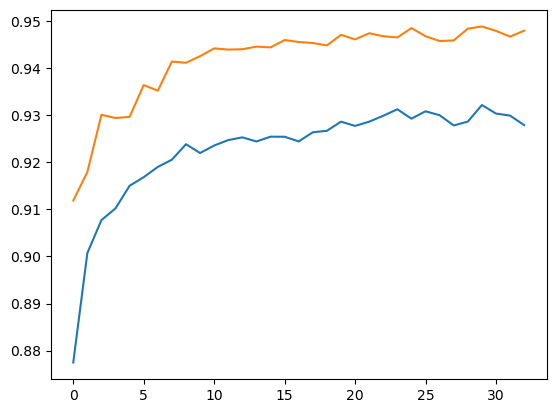

In [54]:
plt.plot(range(33), history.history['accuracy'])
plt.plot(range(33), history.history['val_accuracy'])

In [47]:
import numpy as np
np.round(y_pred_prob)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

(array([26418.,   947.,   801.,   938.,  4200.,   818.,   644.,   762.,
         1081., 34175.]),
 array([1.41081642e-32, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

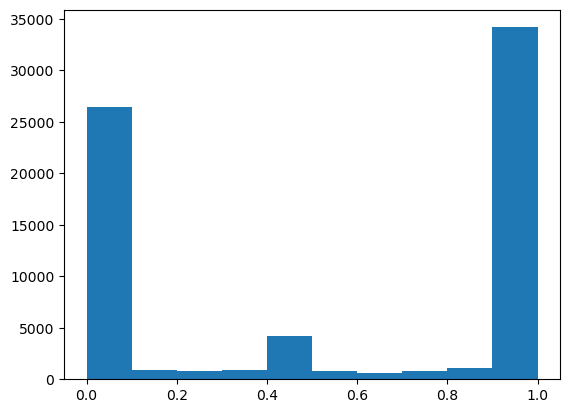

In [43]:
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)

### Submissions

### Gradient Boosting

In [ ]:
y_pred_gb = gb_model.predict(X_test)

In [33]:
predictions = pd.DataFrame(y_pred_rf)
predictions['ID'] = test_df['ID']

predictions = predictions[['ID', 0]]
predictions.columns = ['ID', 'Overall_Experience']
predictions

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1
...,...,...
35597,99935598,0
35598,99935599,1
35599,99935600,1
35600,99935601,1


In [35]:
predictions.to_csv('../output/submission.csv', sep=';', index=False)

### Random Forest

In [27]:
y_pred_rf = rf_model.predict(X_test)

In [33]:
predictions = pd.DataFrame(y_pred_rf)
predictions['ID'] = test_df['ID']

predictions = predictions[['ID', 0]]
predictions.columns = ['ID', 'Overall_Experience']
predictions

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1
...,...,...
35597,99935598,0
35598,99935599,1
35599,99935600,1
35600,99935601,1


In [35]:
predictions.to_csv('../output/submission.csv', sep=';', index=False)

### XGBoost

In [166]:
y_pred_xgb = xgboost.predict(X_test)

In [167]:
predictions = pd.DataFrame(y_pred_xgb)
predictions['ID'] = test_df['ID']

predictions = predictions[['ID', 0]]
predictions.columns = ['ID', 'Overall_Experience']
predictions

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1
...,...,...
35597,99935598,0
35598,99935599,1
35599,99935600,0
35600,99935601,1


In [168]:
predictions.to_csv('../../output/submission_xgb.csv', sep=';', index=False)